In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi

Fri May 24 09:10:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Directories
data_dir = '/content/drive/MyDrive/Colab/112-2-DLA/final/data'
data_dir

'/content/drive/MyDrive/Colab/112-2-DLA/final/data'

In [6]:
config = {
    'train_ratio': 0.8,
    'valid_ratio': 0.1,
    'test_ratio': 0.1,
    'batch_size': 64,
    'num_epochs': 30,
}

In [7]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms)
full_dataset

Dataset ImageFolder
    Number of datapoints: 5250
    Root location: /content/drive/MyDrive/Colab/112-2-DLA/final/data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import DataLoader, Subset

# Assuming full_dataset is a torchvision dataset or similar
targets = np.array(full_dataset.targets)  # Extract the target labels

# Define the split ratios
train_ratio, val_ratio = config['train_ratio'], config['valid_ratio']
test_ratio = 1 - train_ratio - val_ratio

# First stratified split to get training set and temporary set (validation + test)
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_idx, temp_idx = next(sss_train.split(np.zeros(len(targets)), targets))

# Extract the targets for the temporary set
temp_targets = targets[temp_idx]

# Second stratified split to split the temporary set into validation and test sets
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=620)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_targets)), temp_targets))

# Map the indices back to the original dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create the Subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

# Dataloaders and dataset sizes
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Class names
class_names = full_dataset.classes
class_names

['battery',
 'glass',
 'metal',
 'normal plastic',
 'paper',
 'paper container',
 'plastic bottle']

In [9]:
# Model
from torchvision.models import MobileNet_V3_Large_Weights

model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 62.4MB/s]


In [10]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_val_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train model
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=config['num_epochs'])


Epoch 0/29


train Loss: 1.7625 Acc: 0.4024


val Loss: 1.4501 Acc: 0.6838
Epoch 1/29


train Loss: 1.2271 Acc: 0.7043


val Loss: 0.9493 Acc: 0.7733
Epoch 2/29


train Loss: 0.7756 Acc: 0.7667


val Loss: 0.6807 Acc: 0.8343
Epoch 3/29


train Loss: 0.5728 Acc: 0.8212


val Loss: 0.5370 Acc: 0.8457
Epoch 4/29


train Loss: 0.4892 Acc: 0.8410


val Loss: 0.4033 Acc: 0.8838
Epoch 5/29


train Loss: 0.4184 Acc: 0.8626


val Loss: 0.3579 Acc: 0.9086
Epoch 6/29


train Loss: 0.3740 Acc: 0.8755


val Loss: 0.3076 Acc: 0.9105
Epoch 7/29


train Loss: 0.3329 Acc: 0.8902


val Loss: 0.3196 Acc: 0.8895
Epoch 8/29


train Loss: 0.3098 Acc: 0.8945


val Loss: 0.3113 Acc: 0.8952
Epoch 9/29


train Loss: 0.2859 Acc: 0.9081


val Loss: 0.2702 Acc: 0.9067
Epoch 10/29


train Loss: 0.2633 Acc: 0.9119


val Loss: 0.2972 Acc: 0.9162
Epoch 11/29


train Loss: 0.2613 Acc: 0.9117


val Loss: 0.2471 Acc: 0.9238
Epoch 12/29


train Loss: 0.2467 Acc: 0.9186


val Loss: 0.2619 Acc: 0.9124
Epoch 13/29


train Loss: 0.2335 Acc: 0.9226


val Loss: 0.2400 Acc: 0.9219
Epoch 14/29


train Loss: 0.2087 Acc: 0.9345


val Loss: 0.2041 Acc: 0.9200
Epoch 15/29


train Loss: 0.2056 Acc: 0.9329


val Loss: 0.2278 Acc: 0.9295
Epoch 16/29


train Loss: 0.1911 Acc: 0.9355


val Loss: 0.2143 Acc: 0.9276
Epoch 17/29


train Loss: 0.1991 Acc: 0.9348


val Loss: 0.2210 Acc: 0.9295
Epoch 18/29


train Loss: 0.1778 Acc: 0.9426


val Loss: 0.2241 Acc: 0.9314
Epoch 19/29


train Loss: 0.1700 Acc: 0.9452


val Loss: 0.1873 Acc: 0.9295
Epoch 20/29


train Loss: 0.1803 Acc: 0.9419


val Loss: 0.1831 Acc: 0.9390
Epoch 21/29


train Loss: 0.1780 Acc: 0.9402


val Loss: 0.2065 Acc: 0.9257
Epoch 22/29


train Loss: 0.1445 Acc: 0.9531


val Loss: 0.2649 Acc: 0.9143
Epoch 23/29


train Loss: 0.1420 Acc: 0.9517


val Loss: 0.1754 Acc: 0.9524
Epoch 24/29


train Loss: 0.1574 Acc: 0.9488


val Loss: 0.2224 Acc: 0.9257
Epoch 25/29


train Loss: 0.1378 Acc: 0.9548


val Loss: 0.1735 Acc: 0.9390
Epoch 26/29


train Loss: 0.1389 Acc: 0.9550


val Loss: 0.1886 Acc: 0.9314
Epoch 27/29


train Loss: 0.1393 Acc: 0.9543


val Loss: 0.1390 Acc: 0.9638
Epoch 28/29


train Loss: 0.1363 Acc: 0.9538


val Loss: 0.1633 Acc: 0.9467
Epoch 29/29


train Loss: 0.1303 Acc: 0.9612


val Loss: 0.1635 Acc: 0.9371
Best val Acc: 0.9638


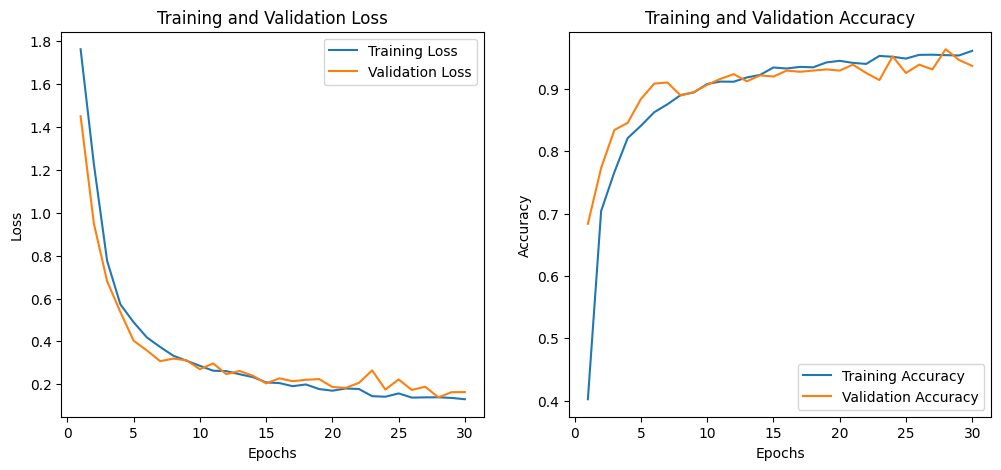

In [11]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Test Loss: 0.2532 Acc: 0.9219


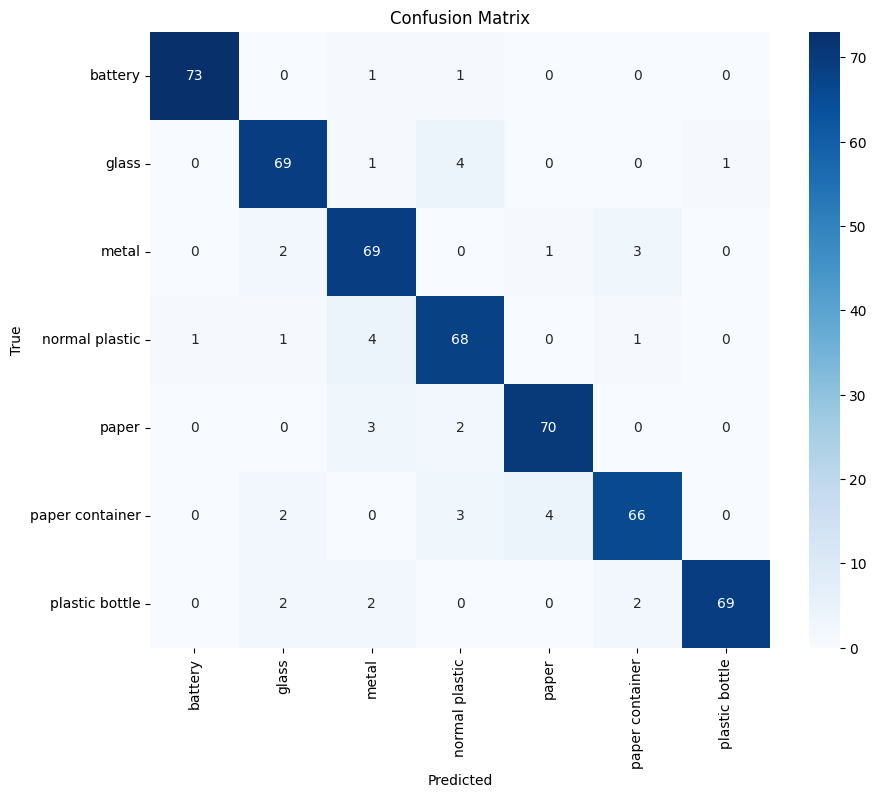


Classification Report:
                 precision    recall  f1-score   support

        battery       0.99      0.97      0.98        75
          glass       0.91      0.92      0.91        75
          metal       0.86      0.92      0.89        75
 normal plastic       0.87      0.91      0.89        75
          paper       0.93      0.93      0.93        75
paper container       0.92      0.88      0.90        75
 plastic bottle       0.99      0.92      0.95        75

       accuracy                           0.92       525
      macro avg       0.92      0.92      0.92       525
   weighted avg       0.92      0.92      0.92       525

Weighted F1 Score: 0.9223
Macro-average F1 Score: 0.9223
Micro-average F1 Score: 0.9219


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Evaluate model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {loss:.4f} Acc: {acc:.4f}')

    return all_labels, all_preds

# Evaluate on the test set
all_labels, all_preds = evaluate_model(model, dataloaders['test'])

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print('\nClassification Report:')
print(class_report)

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

# Macro- and Micro-average F1 Scores
macro_f1 = f1_score(all_labels, all_preds, average='macro')
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Macro-average F1 Score: {macro_f1:.4f}')
print(f'Micro-average F1 Score: {micro_f1:.4f}')

In [13]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/112-2-DLA/final/mobilenetV3.ckpt')